### PPO3 (image + vector obs based fusion network)
We designed this architecture because relying solely on image input lacks explicit distance awareness, making obstacle avoidance significantly weaker. Additionally, image-only agents tend to generalize poorly across diverse driving scenarios. By integrating LiDAR data into the observation space, we enhance the agent's perception of surrounding objects and improve its ability to navigate safely and adapt to new environments.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from torch.distributions import Normal
import matplotlib.pyplot as plt
from metadrive.envs.top_down_env import TopDownMetaDrive
from metadrive.utils import clip

In [2]:
# Training hyperparameters
SEED = 42
TOTAL_EPOCHS = 100
EPISODES_PER_BATCH = 32
GAMMA = 0.9
GAE_LAMBDA = 0.95
CLIP_EPS = 0.07
PPO_STEPS = 10
BATCH_SIZE = 64
ACTOR_LR = 5e-5
CRITIC_LR = 1e-3
ENTROPY_COEF = 0.01
SAVE_EVERY = 10
RENDER_EVERY = 20
VIDEO_DIR = "ppo3_checkpoints/videos"
MODEL_DIR = "ppo3_checkpoints/models"

np.random.seed(SEED)
torch.manual_seed(SEED)

# Convert image observations to tensors (B, C, H, W)
def preprocess_obs(obs_list, device):
    return torch.tensor(np.stack(obs_list), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

def preprocess_vec(vec_list, device):
    return torch.tensor(np.stack(vec_list), dtype=torch.float32, device=device)

def compute_gae(rewards, values, gamma=GAMMA, lam=GAE_LAMBDA):
    advantages = []
    gae = 0
    values = values + [0.0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        gae = delta + gamma * lam * gae
        advantages.insert(0, gae)
    returns = [adv + v for adv, v in zip(advantages, values[:-1])]
    return advantages, returns

def squash_log_prob(dist, raw_action, tanh_action):
    log_prob = dist.log_prob(raw_action).sum(dim=-1)
    log_prob -= torch.log(1 - tanh_action.pow(2) + 1e-6).sum(dim=-1)
    return log_prob


In [3]:
def extract_vector_obs(env):
    ego = env.agent
    vec = []
    vec.append(ego.speed_km_h / ego.config["max_speed_km_h"])
    _, lateral = ego.lane.local_coordinates(ego.position)
    lane_width = ego.navigation.get_current_lane_width()
    vec.append(lateral / (lane_width / 2))
    closest_dist = 30.0
    rel_speed = 0.0
    front_angle_dot = 0.0
    for other in env.agents.values():
        if other.id == ego.id:
            continue
        rel_pos = other.position - ego.position
        dist = np.linalg.norm(rel_pos)
        if dist < closest_dist:
            direction = rel_pos / (np.linalg.norm(rel_pos) + 1e-6)
            heading = ego.heading_unit_vector
            front_dot = np.dot(direction, heading)
            if front_dot > 0.7:
                closest_dist = dist
                rel_speed = (other.speed_km_h - ego.speed_km_h) / ego.config["max_speed_km_h"]
                front_angle_dot = front_dot
    vec.append(closest_dist / 30.0)
    vec.append(rel_speed)
    vec.append(front_angle_dot)
    return np.array(vec, dtype=np.float32)

def extract_lidar_obs(env):
    ego = env.agent
    physics_world = env.engine.physics_world.dynamic_world
    num_lasers = ego.config["lidar"]["num_lasers"]
    distance = ego.config["lidar"]["distance"]

    distances, _ = ego.lidar.perceive(
        base_vehicle=ego,
        physics_world=physics_world,
        num_lasers=num_lasers,
        distance=distance
    )
    return np.array(distances, dtype=np.float32)

In [4]:
@torch.no_grad()
def record_video(actor, env, device, epoch, max_frames=1000):
    os.makedirs(VIDEO_DIR, exist_ok=True)
    frames = []
    obs, _ = env.reset()
    for _ in range(max_frames):
        obs_tensor = preprocess_obs([obs], device)
        vec = extract_vector_obs(env)
        lidar = extract_lidar_obs(env)
        vec_tensor = preprocess_vec([vec], device)
        lidar_tensor = preprocess_vec([lidar], device)

        mu, std = actor(obs_tensor, vec_tensor, lidar_tensor)
        dist = Normal(mu, std)
        raw_action = dist.mean
        action = torch.tanh(raw_action).squeeze(0).cpu().numpy()
        img = env.render(mode="topdown")
        if img is not None:
            frames.append(img)
        obs, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    path = os.path.join(VIDEO_DIR, f"video_epoch_{epoch}.mp4")
    imageio.mimsave(path, frames, fps=15)
    print(f"[Video] Saved to {path}")
    

In [5]:
def custom_reward_function(env, vehicle_id):
    vehicle = env.agents[vehicle_id]
    step_info = dict()

    if vehicle.lane in vehicle.navigation.current_ref_lanes:
        current_lane = vehicle.lane
        positive_road = 1
    else:
        current_lane = vehicle.navigation.current_ref_lanes[0]
        current_road = vehicle.navigation.current_road
        positive_road = 1 if not current_road.is_negative_road() else -1
    long_last, _ = current_lane.local_coordinates(vehicle.last_position)
    long_now, lateral_now = current_lane.local_coordinates(vehicle.position)

    if env.config["use_lateral_reward"]:
        lateral_factor = clip(1 - 2 * abs(lateral_now) / vehicle.navigation.get_current_lane_width(), 0.0, 1.0)
    else:
        lateral_factor = 1.0

    reward = 0.0
    reward += env.config["driving_reward"] * (long_now - long_last) * lateral_factor * positive_road
    reward += env.config["speed_reward"] * (vehicle.speed_km_h / vehicle.max_speed_km_h) * positive_road

    # Front vehicle shaping
    for other in env.agents.values():
        if other.id == vehicle.id:
            continue
        rel_pos = other.position - vehicle.position
        dist = np.linalg.norm(rel_pos)
        direction = rel_pos / (np.linalg.norm(rel_pos) + 1e-6)
        front_dot = np.dot(vehicle.heading_unit_vector, direction)
        if dist < 20 and front_dot > 0.7:
            rel_speed = other.speed - vehicle.speed
            if 0 <= rel_speed <= 0.5:
                r_follow = 1 - rel_speed / 0.5
                reward += 0.5 * r_follow

    # LIDAR-based shaping
    if hasattr(vehicle, "lidar"):
        distances, _ = vehicle.lidar.perceive(
            base_vehicle=vehicle,
            physics_world=env.engine.physics_world.dynamic_world,
            num_lasers=120,
            distance=30
        )
        distances = np.clip(distances, 0, 30)
        left = distances[30:45]    # approx. 90° ± 22.5°
        right = distances[75:90]   # approx. 270° ± 22.5°
        front = distances[52:67]   # approx. 0° ± 22.5°

        if np.min(left) > 0.8 and np.min(right) > 0.8:
            reward += 0.3
        if np.min(distances) > 0.3:
            reward += 0.3
        if np.min(front) < 25:
            safe_to_left = np.min(left) > 3.0
            safe_to_right = np.min(right) > 3.0
            _, lateral = vehicle.lane.local_coordinates(vehicle.position)
            is_changing_lane = abs(lateral) > 0.8
            if is_changing_lane and (safe_to_left or safe_to_right):
                reward += 0.3

    # Termination penalties
    step_info["step_reward"] = reward

    if env._is_arrive_destination(vehicle):
        reward = +env.config["success_reward"]
    elif env._is_out_of_road(vehicle):
        reward = -env.config["out_of_road_penalty"]
    elif vehicle.crash_vehicle:
        reward = -env.config["crash_vehicle_penalty"]
    elif vehicle.crash_object:
        reward = -env.config["crash_object_penalty"]
    elif vehicle.crash_sidewalk:
        reward = -env.config["crash_sidewalk_penalty"]
    step_info["route_completion"] = vehicle.navigation.route_completion

    return reward, step_info

In [6]:
# Actor-Critic with Image + Vector input
class FusionActor(nn.Module):
    def __init__(self, vector_input_dim=5, lidar_dim=120):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU()
        )
        self.image_fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256),
            nn.ReLU()
        )
        self.vector_fc = nn.Sequential(
            nn.Linear(vector_input_dim, 64),
            nn.ReLU()
        )
        self.lidar_fc = nn.Sequential(
            nn.Linear(lidar_dim, 128),
            nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(256 + 64 + 128, 256),
            nn.ReLU()
        )
        self.mu = nn.Linear(256, 2)
        self.log_std = nn.Parameter(torch.full((2,), -0.5))

    def forward(self, image_obs, vector_obs, lidar_obs):
        x_img = self.conv(image_obs)
        x_img = self.image_fc(torch.flatten(x_img, 1))
        x_vec = self.vector_fc(vector_obs)
        x_lidar = self.lidar_fc(lidar_obs)
        x = self.fusion(torch.cat([x_img, x_vec, x_lidar], dim=1))
        mu = self.mu(x)
        std = self.log_std.exp().expand_as(mu)
        return mu, std

class FusionCritic(nn.Module):
    def __init__(self, vector_input_dim=5, lidar_dim=120):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU()
        )
        self.image_fc = nn.Sequential(
            nn.Linear(32 * 9 * 9, 256),
            nn.ReLU()
        )
        self.vector_fc = nn.Sequential(
            nn.Linear(vector_input_dim, 64),
            nn.ReLU()
        )
        self.lidar_fc = nn.Sequential(
            nn.Linear(lidar_dim, 128),
            nn.ReLU()
        )
        self.fusion = nn.Sequential(
            nn.Linear(256 + 64 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, image_obs, vector_obs, lidar_obs):
        x_img = self.conv(image_obs)
        x_img = self.image_fc(torch.flatten(x_img, 1))
        x_vec = self.vector_fc(vector_obs)
        x_lidar = self.lidar_fc(lidar_obs)
        x = self.fusion(torch.cat([x_img, x_vec, x_lidar], dim=1))
        return x.squeeze(-1)

In [7]:
def train(env):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    actor = FusionActor().to(device)
    critic = FusionCritic().to(device)
    actor_optim = optim.Adam(actor.parameters(), lr=ACTOR_LR)
    critic_optim = optim.Adam(critic.parameters(), lr=CRITIC_LR)
    all_returns, actor_losses, critic_losses = [], [], []

    for epoch in range(1, TOTAL_EPOCHS + 1):
        obs_list, vec_list, lidar_list, actions, logps, rewards, values = [], [], [], [], [], [], []
        for _ in range(EPISODES_PER_BATCH):
            obs, _ = env.reset()
            done = False
            while not done:
                vec = extract_vector_obs(env)
                lidar = extract_lidar_obs(env)
                obs_tensor = preprocess_obs([obs], device)
                vec_tensor = preprocess_vec([vec], device)
                lidar_tensor = preprocess_vec([lidar], device)
                mu, std = actor(obs_tensor, vec_tensor, lidar_tensor)
                dist = Normal(mu, std)
                raw_action = dist.rsample()
                action = torch.tanh(raw_action)
                log_prob = squash_log_prob(dist, raw_action, action)
                value = critic(obs_tensor, vec_tensor, lidar_tensor)

                obs_list.append(obs)
                vec_list.append(vec)
                lidar_list.append(lidar)
                actions.append(action[0].detach().cpu().numpy())
                logps.append(log_prob.item())
                values.append(value.item())

                obs, reward, terminated, truncated, _ = env.step(action[0].detach().cpu().numpy())
                rewards.append(reward)
                done = terminated or truncated

        advantages, returns = compute_gae(rewards, values)
        image_tensor = preprocess_obs(obs_list, device)
        vec_tensor = preprocess_vec(vec_list, device)
        lidar_tensor = preprocess_vec(lidar_list, device)
        act_tensor = torch.tensor(actions, dtype=torch.float32, device=device)
        logp_old = torch.tensor(logps, dtype=torch.float32, device=device)
        adv_tensor = torch.tensor(advantages, dtype=torch.float32, device=device)
        rtg_tensor = torch.tensor(returns, dtype=torch.float32, device=device)
        adv_tensor = (adv_tensor - adv_tensor.mean()) / (adv_tensor.std() + 1e-8)

        for _ in range(PPO_STEPS):
            mu, std = actor(image_tensor, vec_tensor, lidar_tensor)
            dist = Normal(mu, std)
            raw_action = torch.atanh(torch.clamp(act_tensor, -0.999, 0.999))
            logp = squash_log_prob(dist, raw_action, act_tensor)
            ratio = torch.exp(logp - logp_old)
            surr1 = ratio * adv_tensor
            surr2 = torch.clamp(ratio, 1 - CLIP_EPS, 1 + CLIP_EPS) * adv_tensor
            actor_loss = -torch.min(surr1, surr2).mean()
            value = critic(image_tensor, vec_tensor, lidar_tensor)
            critic_loss = F.mse_loss(value, rtg_tensor)
            actor_optim.zero_grad()
            actor_loss.backward()
            actor_optim.step()
            critic_optim.zero_grad()
            critic_loss.backward()
            critic_optim.step()

        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        all_returns.append(np.mean(rewards))

        print(f"Epoch {epoch}: Return={np.mean(rewards):.2f}, Actor Loss={actor_loss.item():.4f}, Critic Loss={critic_loss.item():.4f}")

        if epoch % SAVE_EVERY == 0:
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(actor.state_dict(), os.path.join(MODEL_DIR, f"actor_epoch_{epoch}.pth"))
            torch.save(critic.state_dict(), os.path.join(MODEL_DIR, f"critic_epoch_{epoch}.pth"))

    env.close()

    plt.plot(all_returns)
    plt.xlabel("Epoch")
    plt.ylabel("Average Return")
    plt.title("Average Return per Epoch")
    plt.grid()
    plt.show()

    plt.plot(actor_losses, label="Actor Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Actor & Critic Loss")
    plt.legend()
    plt.grid()
    plt.show()


In [8]:
def test_fixed_scenarios(fixed_scenarios, model_path, gif_dir="ppo3_tests_gifs"):
    os.makedirs(gif_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    actor = FusionActor().to(device)
    actor.load_state_dict(torch.load(model_path, map_location=device))
    actor.eval()
    print(f"[INFO] Loaded actor from {model_path}")

    for scenario_id in fixed_scenarios:
        env = TopDownMetaDrive(dict(
            use_render=True,
            manual_control=False,
            horizon=500,
            num_scenarios=1,
            start_seed=scenario_id,
            vehicle_config={"lidar": {"num_lasers": 120, "distance": 30}}
        ))

        obs, _ = env.reset()
        rewards = []
        frames = []

        while True:
            frame = env.render(mode="topdown")
            if frame is not None:
                frames.append(frame)
            vec = extract_vector_obs(env)
            lidar = extract_lidar_obs(env)
            obs_tensor = preprocess_obs([obs], device)
            vec_tensor = preprocess_vec([vec], device)
            lidar_tensor = preprocess_vec([lidar], device)
            mu, std = actor(obs_tensor, vec_tensor, lidar_tensor)
            dist = Normal(mu, std)
            action = torch.tanh(dist.mean)[0].detach().cpu().numpy()
            obs, reward, terminated, truncated, _ = env.step(action)
            rewards.append(reward)
            if terminated or truncated:
                break
        env.close()
        gif_path = os.path.join(gif_dir, f"scenario_{scenario_id}.gif")
        imageio.mimsave(gif_path, frames, fps=20)
        print(f"Saved GIF for scenario {scenario_id} (reward={sum(rewards):.2f}) to {gif_path}")


[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): 300
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 100
/var/folders/4r/46cgs67x2jb3cbzcd8tf87l80000gn/T/ipykernel_81396/4047370661.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  act_tensor = torch.tensor(actions, dtype=torch.float32, device=device)


Epoch 1: Return=0.61, Actor Loss=-0.0084, Critic Loss=0.6284
Epoch 2: Return=0.61, Actor Loss=-0.0054, Critic Loss=0.3630
Epoch 3: Return=0.62, Actor Loss=-0.0048, Critic Loss=0.0718
Epoch 4: Return=0.62, Actor Loss=-0.0049, Critic Loss=0.1474
Epoch 5: Return=0.63, Actor Loss=-0.0030, Critic Loss=0.1441
Epoch 6: Return=0.63, Actor Loss=-0.0033, Critic Loss=0.2391
Epoch 7: Return=0.64, Actor Loss=-0.0024, Critic Loss=0.3455
Epoch 8: Return=0.65, Actor Loss=-0.0021, Critic Loss=0.4276
Epoch 9: Return=0.67, Actor Loss=-0.0030, Critic Loss=0.3329
Epoch 10: Return=0.67, Actor Loss=-0.0023, Critic Loss=0.5358
Epoch 11: Return=0.68, Actor Loss=-0.0017, Critic Loss=0.5621
Epoch 12: Return=0.72, Actor Loss=-0.0039, Critic Loss=0.5323
Epoch 13: Return=0.72, Actor Loss=-0.0028, Critic Loss=0.7009
Epoch 14: Return=0.76, Actor Loss=-0.0055, Critic Loss=0.6931
Epoch 15: Return=0.77, Actor Loss=-0.0035, Critic Loss=0.7478
Epoch 16: Return=0.78, Actor Loss=-0.0039, Critic Loss=0.7636
Epoch 17: Return=

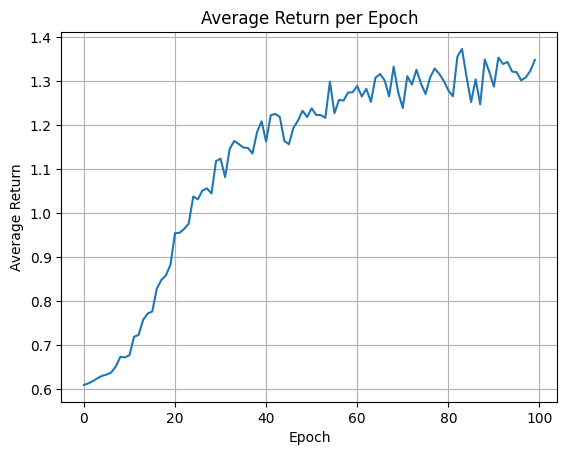

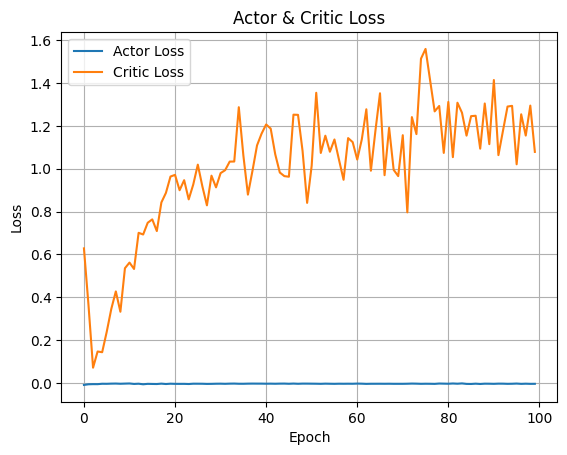

In [9]:
if __name__ == "__main__":
    env = TopDownMetaDrive(dict(
        use_render=False,
        horizon=300,
        num_scenarios=100,
        traffic_density=0.1,
        vehicle_config=dict(
            show_lidar=True,
            lidar=dict(num_lasers=120, distance=30)
        )
    ))
    env.reward_function = lambda vehicle_id: custom_reward_function(env, vehicle_id)
    train(env)


In [ ]:
    env.close()
    fixed_scenarios = [0, 5, 12, 37, 89]
    test_fixed_scenarios(fixed_scenarios, model_path="ppo3_checkpoints/models/actor_epoch_100.pth")    

[INFO] Environment: TopDownMetaDrive


[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500


[INFO] Loaded actor from ppo3_checkpoints/models/actor_epoch_100.pth


2025-05-01 22:27:12.786 Python[81396:16267771] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3


Saved GIF for scenario 0 (reward=103.94) to ppo3_tests_gifs/scenario_0.gif


[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)
[INFO] Start Scenario Index: 5, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)


Saved GIF for scenario 5 (reward=66.74) to ppo3_tests_gifs/scenario_5.gif


[INFO] Start Scenario Index: 12, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)


Saved GIF for scenario 12 (reward=69.82) to ppo3_tests_gifs/scenario_12.gif


[INFO] Start Scenario Index: 37, Num Scenarios : 1
[INFO] Environment: TopDownMetaDrive
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): 500
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[WARNING] Since your screen is too small (1470, 956), we resize the window to (1147, 860). (engine_core.py:234)


Saved GIF for scenario 37 (reward=74.81) to ppo3_tests_gifs/scenario_37.gif


[INFO] Start Scenario Index: 89, Num Scenarios : 1


Saved GIF for scenario 89 (reward=144.20) to ppo3_tests_gifs/scenario_89.gif


: 